In [1]:
#### importing original data ####
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns 
import re 
%matplotlib inline
import glob
from tqdm import tqdm


In [2]:
location ='/project/Dolatshahi_Lab/Data_From_Ileanna/nardine_object_data_lung_cancer_brown071921.csv'


#### Brown Data #### 
#reduced_titles = ['Image Location','XMin','XMax','YMin','YMax','MHCI (Opal 650) Positive','CD56 (Opal 570) Positive','CD8 (Opal 540) Positive','CD3 (Opal 520) Positive','CD56+CD3+','CD56+CD3-','CD8+IFNy+','CD3+IFNy+','CD56+IFNy+','CD8-CD3+','CD8+CD3+','CD8+CD3-','panCK+MHCI+','panCK+MHCI-', 'IFNy (Opal 620) Positive', 'Classifier Label', 'PanCyto (Opal 690) Positive', 'Cell Area (µm²)', 'DAPI Positive']
originalData = pd.read_csv(location)
#originalData = pd.read_csv(location, usecols = reduced_titles)

# Goal/Plan 
## process the data using the logic outlined in nsclc_quality_control.ipynb
### things to look out for: duplicated data, multiple runs stacked together (classifying as mhc+ and again as mhc1+), glass, slides with very low cell positivity
## Then after processing start running some analysis on cell counts 
### compare activated vs unactivated cells by patient (cd8, cd3, cd56), mhc1+ vs mhc1- panck by patient, immune cell type in stroma vs tumor (act vs inact cd8, cd3,cd56), etc
### then run the neighbor finding algorithm to get neighborhood scores 

In [3]:
# 8503 rows are NA across the board except for region area and region perimeter, ill drop these first
df = originalData.dropna(subset='Nucleus Roundness')

In [4]:
# alright, lets start making some new and useful metadata columns

df["ROI"] = df["Image Location"].str.extract(r'MAD(.*?\])')
df["PatientID"] = df["Image Location"].str.extract(r'([^MAD]*[0-9][0-9]-[0-9][0-9][0-9])') 

# scaling from pixels to microns -> GH comment (is this a problem? should we be rounding this since we only have accuracy to about 0.5 microns
df["XMin"]  = df["XMin"]*0.49456
df["XMax"]  = df["XMax"]*0.49456
df["YMin"]  = df["YMin"]*0.49456
df["YMax"]  = df["YMax"]*0.49456
df['XCenter'] = (df["XMin"] +df["XMax"])/2
df['YCenter'] = (df["YMin"] +df["YMax"])/2

/tmp/ipykernel_808196/665725146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ROI"] = df["Image Location"].str.extract(r'MAD(.*?\])')
/tmp/ipykernel_808196/665725146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PatientID"] = df["Image Location"].str.extract(r'([^MAD]*[0-9][0-9]-[0-9][0-9][0-9])')
/tmp/ipykernel_808196/665725146.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [5]:
# grab the positive intensity columns for the stains
import difflib

reduced_titles = ['Image Location','XMin','XMax','YMin','YMax','MHCI (Opal 650) Positive','CD56 (Opal 570) Positive','CD8 (Opal 540) Positive','CD3 (Opal 520) Positive',"IFNy (Opal 620) Positive", 'IFNy (Opal 620) Cytoplasm Intensity', 'PanCyto (Opal 690) Positive','Classifier Label', 'ROI', 'Patient Id', 'XCenter', 'YCenter', 'Cell Area (µm²)','Cytoplasm Area (µm²)','Membrane Area (µm²)','Nucleus Area (µm²)','Nucleus Perimeter (µm)','Nucleus Roundness']

# Iterate through provided columns and find closest matches in actual DataFrame columns; this csv was encoded really weird 
selected_columns = []
for col in reduced_titles:
    closest_match = difflib.get_close_matches(col, df.columns)
    if closest_match:
        selected_columns.append(closest_match[0])

# Select the columns in the DataFrame
subset_df = df[selected_columns]

# get column naming format to match Kate's and reset the index
subset_df = subset_df.rename(columns = {'Classifier Label': 'ClassifierLabel','Image Location':'ImageLocation',"Cell Area (µm²)":'CellArea'})
subset_df = subset_df.reset_index()
subset_df = subset_df.drop('index', axis=1) 
subset_df


,ImageLocation,XMin,XMax,YMin,YMax,MHCI (Opal 650) Positive,CD56 (Opal 570) Positive,CD8 (Opal 540) Positive,CD3 (Opal 520) Positive,IFNy (Opal 620) Positive,...,ROI,PatientID,XCenter,YCenter,CellArea,Cytoplasm Area (µm²),Membrane Area (µm²),Nucleus Area (µm²),Nucleus Perimeter (µm),Nucleus Roundness
0,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,2000.00064,2008.40816,402.57184,410.97936,0.0,0.0,0.0,0.0,0.0,...,"15-517_[39953,11936]",15-517,2004.20440,406.77560,62.12640,33.50912,0.0,28.61728,21.76075,0.801868
1,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,1982.19648,1989.61488,575.66784,585.06448,0.0,0.0,0.0,0.0,0.0,...,"15-517_[39953,11936]",15-517,1985.90568,580.36616,58.21293,33.01994,0.0,25.19299,21.76075,0.734622
2,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,1998.02240,2006.42992,696.34048,705.24256,0.0,0.0,0.0,0.0,0.0,...,"15-517_[39953,11936]",15-517,2002.22616,700.79152,63.83855,34.24290,0.0,29.59565,22.74988,0.770489
3,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,1106.82528,1115.72736,172.60144,181.50352,0.0,0.0,0.0,0.0,0.0,...,"15-517_[39953,11936]",15-517,1111.27632,177.05248,66.28447,34.24290,0.0,32.04157,23.73900,0.843129
4,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,879.32768,885.26240,181.50352,188.42736,0.0,0.0,0.0,0.0,0.0,...,"15-517_[39953,11936]",15-517,882.29504,184.96544,35.71045,23.48084,0.0,12.22961,13.84775,0.750826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046280,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,1132.04784,1141.44448,1493.07664,1501.48416,0.0,0.0,0.0,0.0,0.0,...,"17-071_[47054,12703]",17-071,1136.74616,1497.28040,62.61559,35.71045,0.0,26.90513,24.72813,0.698552
7046281,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,796.24160,804.15456,1493.57120,1501.48416,0.0,0.0,0.0,0.0,0.0,...,"17-071_[47054,12703]",17-071,800.19808,1497.52768,53.81027,30.08483,0.0,23.72544,19.78250,0.860588
7046282,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,992.08736,998.51664,1494.56032,1501.48416,0.0,0.0,0.0,0.0,0.0,...,"17-071_[47054,12703]",17-071,995.30200,1498.02224,36.68882,23.72544,0.0,12.96338,14.34231,0.801946
7046283,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,1102.37424,1111.27632,1495.54944,1502.47328,0.0,0.0,0.0,0.0,0.0,...,"17-071_[47054,12703]",17-071,1106.82528,1499.01136,52.34272,30.32942,0.0,22.01329,19.78250,0.747288


In [6]:
df

,Image Location,Analysis Region,Analysis Inputs,Object Id,XMin,XMax,YMin,YMax,MHCI+CD56+,MHCI+CD8+,...,panCyto+MHC+,panCyto+MHC-,panCyto+IFNy+,panCyto-IFNy+,Region Area (μm²),Region Perimeter (μm),ROI,PatientID,XCenter,YCenter
0,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,entire image,Class List:glass | tumor | stroma;Classifier:i...,0,2000.00064,2008.40816,402.57184,410.97936,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"15-517_[39953,11936]",15-517,2004.20440,406.77560
1,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,entire image,Class List:glass | tumor | stroma;Classifier:i...,1,1982.19648,1989.61488,575.66784,585.06448,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"15-517_[39953,11936]",15-517,1985.90568,580.36616
2,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,entire image,Class List:glass | tumor | stroma;Classifier:i...,2,1998.02240,2006.42992,696.34048,705.24256,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"15-517_[39953,11936]",15-517,2002.22616,700.79152
3,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,entire image,Class List:glass | tumor | stroma;Classifier:i...,3,1106.82528,1115.72736,172.60144,181.50352,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"15-517_[39953,11936]",15-517,1111.27632,177.05248
4,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,entire image,Class List:glass | tumor | stroma;Classifier:i...,4,879.32768,885.26240,181.50352,188.42736,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"15-517_[39953,11936]",15-517,882.29504,184.96544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054783,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,entire image,Class List:glass | tumor | stroma;Classifier:i...,4413,1132.04784,1141.44448,1493.07664,1501.48416,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"17-071_[47054,12703]",17-071,1136.74616,1497.28040
7054784,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,entire image,Class List:glass | tumor | stroma;Classifier:i...,4414,796.24160,804.15456,1493.57120,1501.48416,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"17-071_[47054,12703]",17-071,800.19808,1497.52768
7054785,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,entire image,Class List:glass | tumor | stroma;Classifier:i...,4415,992.08736,998.51664,1494.56032,1501.48416,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"17-071_[47054,12703]",17-071,995.30200,1498.02224
7054786,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,entire image,Class List:glass | tumor | stroma;Classifier:i...,4416,1102.37424,1111.27632,1495.54944,1502.47328,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"17-071_[47054,12703]",17-071,1106.82528,1499.01136


In [7]:
for title in subset_df.columns:
    if 'Positive' in title:
        newTitleList = title.split(' ')
        newTitle = newTitleList[0]
        subset_df = subset_df.rename(columns = {title : newTitle})

In [8]:
 # For Brown Data ONLY 
# second interation: cd56+ cells are negative for panck, as are all T cells, plus counting unlabeled cells
subset_df['CD56+PanCyto-'] = subset_df['CD56'] -  subset_df['PanCyto']
subset_df['CD56+PanCyto-'] = subset_df['CD56+PanCyto-'].replace(-1,0)
subset_df['CD56+CD3-'] = subset_df['CD56+PanCyto-'] -  subset_df['CD3']
subset_df['CD56+CD3-'] = subset_df['CD56+CD3-'].replace(-1,0)

#subset_df['CD56+CD3+'] = subset_df['CD56']/2 + subset_df['CD3']/2
#subset_df['CD56+CD3+'] = subset_df['CD56+CD3+'].replace(.5,0)

subset_df['PanCyto+CD3-'] = subset_df['PanCyto'] - subset_df['CD3'] 
subset_df['PanCyto+CD3-'] = subset_df['PanCyto+CD3-'].replace(-1,0)
#subset_df['PanCyto+CD56-'] = subset_df['PanCyto+CD3-'] - subset_df['CD56'] 
#subset_df['PanCyto+CD56-'] = subset_df['PanCyto+CD56-'].replace(-1,0)
subset_df['PanCyto+MHCI+'] = subset_df['PanCyto+CD3-']/2 + subset_df['MHCI']/2
subset_df['PanCyto+MHCI+'] = subset_df['PanCyto+MHCI+'].replace(.5,0)

subset_df['PanCyto+MHCI-'] = subset_df['PanCyto+CD3-'] - subset_df['MHCI'] 
subset_df['PanCyto+MHCI-'] = subset_df['PanCyto+MHCI-'].replace(-1,0)

#subset_df['PanCyto+CD56-'] = subset_df['PanCyto'] -  subset_df['CD56']
#subset_df['PanCyto+CD56-'] = subset_df['PanCyto+CD56-'].replace(-1,0)

#subset_df['PanCyto+CD56+'] = subset_df['PanCyto']/2 + subset_df['CD56']/2
#subset_df['PanCyto+CD56+'] = subset_df['PanCyto+CD56+'].replace(.5,0)

subset_df['PanCyto-CD56-'] = subset_df['PanCyto']*2 - subset_df['CD56']
subset_df['PanCyto-CD56-'] = subset_df['PanCyto-CD56-'].replace(0,0.5)
subset_df['PanCyto-CD56-'] = subset_df['PanCyto-CD56-'].replace(1,0)
subset_df['PanCyto-CD56-'] = subset_df['PanCyto-CD56-'].replace(2,0)
subset_df['PanCyto-CD56-'] = subset_df['PanCyto-CD56-'].replace(0.5,1)
subset_df['PanCyto-CD56-'] = subset_df['PanCyto-CD56-'] - subset_df['CD3']
subset_df['PanCyto-CD56-'] = subset_df['PanCyto-CD56-'].replace(-1,0)

subset_df['CD3+CD8-'] = subset_df['CD3'] -  subset_df['CD8']
subset_df['CD3+CD8-'] = subset_df['CD3+CD8-'].replace(-1,0)

subset_df['CD3+CD8+'] = subset_df['CD3']/2 + subset_df['CD8']/2
subset_df['CD3+CD8+'] = subset_df['CD3+CD8+'].replace(.5,0)

In [10]:
subset_df.ClassifierLabel

0           glass
1           glass
2           glass
3           glass
4           glass
            ...  
7046280    stroma
7046281    stroma
7046282    stroma
7046283    stroma
7046284    stroma
Name: ClassifierLabel, Length: 7046285, dtype: object

In [18]:
composition_counts= {}
for i in tqdm(subset_df['ImageLocation'].unique()):
    slide = subset_df.loc[subset_df.ImageLocation == i]
    slide_single_stain_only = slide[['CD56+CD3-','PanCyto+MHCI+','PanCyto-CD56-', 'PanCyto+MHCI-','CD3+CD8-', 'CD3+CD8+']]
    slide_proportion = slide_single_stain_only.mean()
    slide_proportion['count'] = len(slide)
    composition_counts[i] = slide_proportion
composition_df = pd.DataFrame(composition_counts).T
composition_df

100%|██████████| 587/587 [03:29<00:00,  2.81it/s]


,CD56+CD3-,PanCyto+MHCI+,PanCyto-CD56-,PanCyto+MHCI-,CD3+CD8-,CD3+CD8+,count
"E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[39953,11936]_component_data.tif",0.009760,0.004696,0.486511,0.220790,0.163521,0.107172,10861.0
"E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[38615,16187]_component_data.tif",0.000000,0.000000,0.203911,0.701117,0.053073,0.041899,358.0
"E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[37946,15187]_component_data.tif",0.009586,0.016584,0.314896,0.445073,0.147048,0.063554,10432.0
"E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[37946,13687]_component_data.tif",0.012424,0.006592,0.398453,0.278968,0.203410,0.090390,15776.0
"E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[37946,12187]_component_data.tif",0.005677,0.001958,0.618050,0.210454,0.106891,0.054229,5108.0
...,...,...,...,...,...,...,...
"E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-351_[46111,17002]_component_data.tif",0.006332,0.067542,0.582083,0.184959,0.061132,0.095294,25584.0
"E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-071_[49288,14203]_component_data.tif",0.004972,0.019011,0.702545,0.188944,0.057327,0.027201,6838.0
"E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-071_[48098,15703]_component_data.tif",0.004415,0.018967,0.653695,0.236102,0.063440,0.022727,12232.0
"E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-071_[47281,14203]_component_data.tif",0.000211,0.015283,0.627650,0.353687,0.002395,0.000775,28398.0


In [19]:
len(composition_df.loc[composition_df['PanCyto-CD56-'] >= .95])

36

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'CD56+CD3-'),
  Text(1, 0, 'PanCyto+MHCI+'),
  Text(2, 0, 'PanCyto-CD56-'),
  Text(3, 0, 'PanCyto+MHCI-'),
  Text(4, 0, 'CD3+CD8-'),
  Text(5, 0, 'CD3+CD8+')])

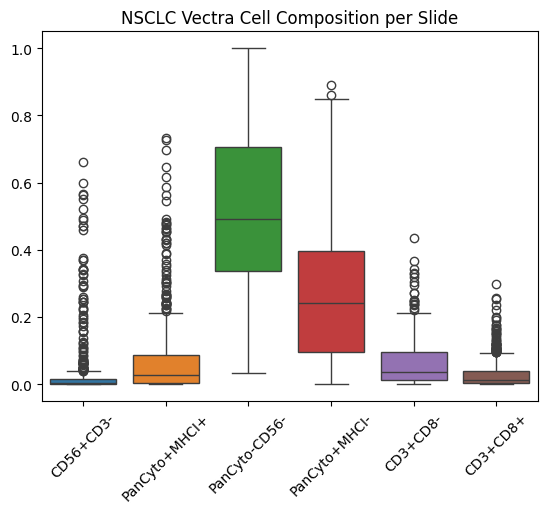

In [20]:
g = sns.boxplot(composition_df.iloc[:,:6])
plt.title('NSCLC Vectra Cell Composition per Slide')
plt.xticks(rotation = 45)

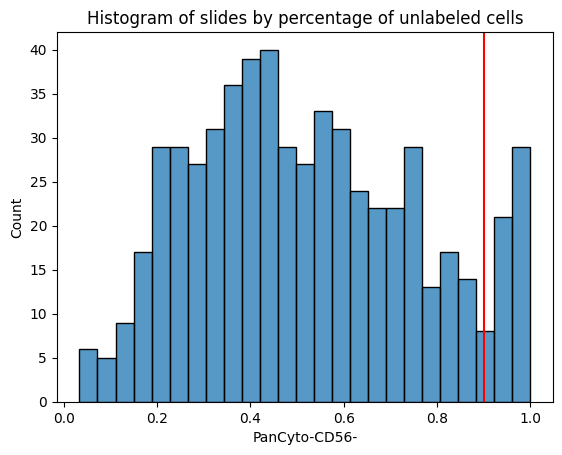

In [21]:
sns.histplot(composition_df['PanCyto-CD56-'], bins = 25)
plt.title('Histogram of slides by percentage of unlabeled cells')
plt.axvline(.9, color = 'r')

In [22]:
# remove anything above 90% unlabeled
filtered = composition_df.loc[composition_df['PanCyto-CD56-'] <= 0.90]
removed = composition_df.loc[composition_df['PanCyto-CD56-'] > 0.90]

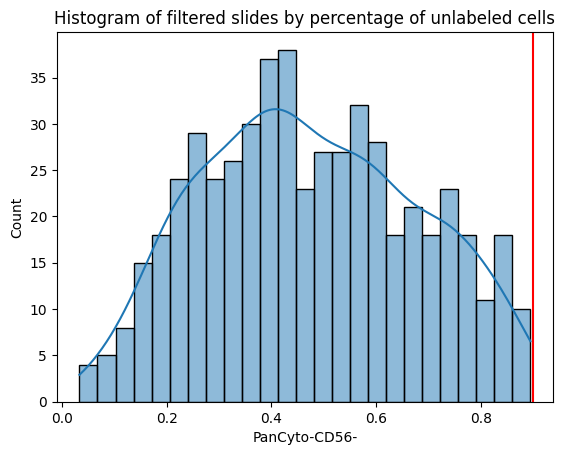

In [23]:
sns.histplot(filtered['PanCyto-CD56-'], bins = 25, kde = True)
plt.title('Histogram of filtered slides by percentage of unlabeled cells')
plt.axvline(.9, color= 'r')

In [24]:
len(filtered.loc[filtered['count'] <= 500])

22

In [25]:
low_count_slides = list(filtered.loc[filtered['count'] <= 500].index)


/tmp/ipykernel_808196/846126578.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)  # Rotate x ticks
/tmp/ipykernel_808196/846126578.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate x ticks


Text(0.5, 0.98, 'Composition for slides with < 500 cells (22 slides) ')

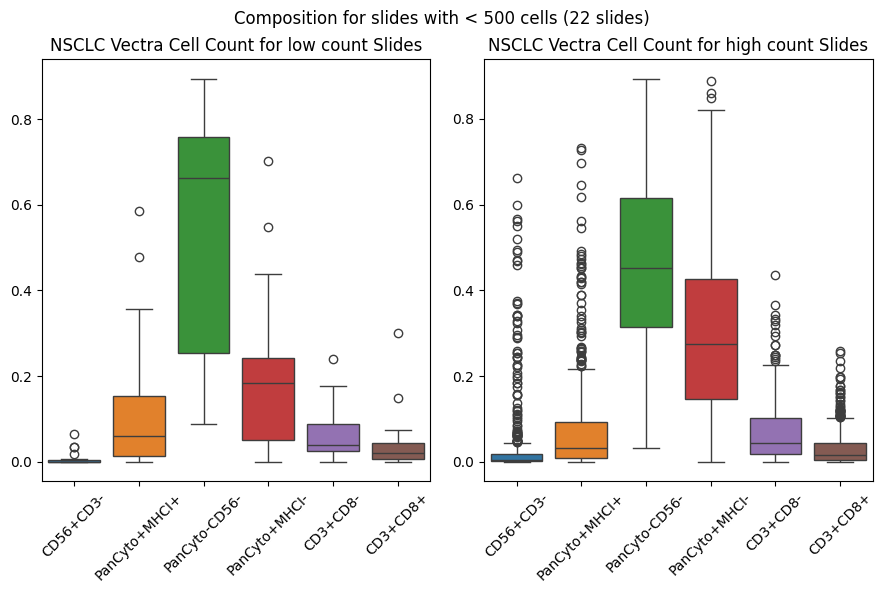

In [26]:
# plotting composition for lowest count slides vs others

figs, axes = plt.subplots(1,2, figsize=(9, 6))
ax1 = sns.boxplot(data = filtered.loc[filtered['count'] <= 500][['CD56+CD3-', 'PanCyto+MHCI+', 'PanCyto-CD56-', 'PanCyto+MHCI-','CD3+CD8-', 'CD3+CD8+']], ax = axes[0])
ax1.set_title('NSCLC Vectra Cell Count for low count Slides')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)  # Rotate x ticks


ax2 = sns.boxplot(data = filtered.loc[filtered['count'] > 500][['CD56+CD3-', 'PanCyto+MHCI+', 'PanCyto-CD56-', 'PanCyto+MHCI-','CD3+CD8-', 'CD3+CD8+']], ax = axes[1])
ax2.set_title('NSCLC Vectra Cell Count for high count Slides')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate x ticks
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Composition for slides with < 500 cells (22 slides) ')

/tmp/ipykernel_808196/3763279866.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)  # Rotate x ticks
/tmp/ipykernel_808196/3763279866.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate x ticks


Text(0.5, 0.98, 'Composition for slides with < 200 cells (9 slides) ')

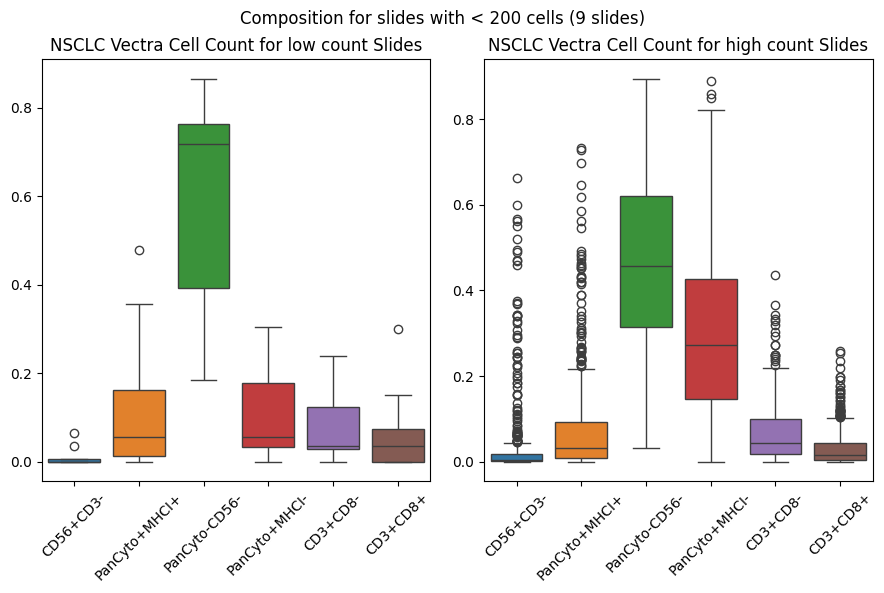

In [27]:
# plotting composition for lowest count slides vs others
# this removes 9 slides
figs, axes = plt.subplots(1,2, figsize=(9, 6))
ax1 = sns.boxplot(data = filtered.loc[filtered['count'] <= 200][['CD56+CD3-', 'PanCyto+MHCI+', 'PanCyto-CD56-', 'PanCyto+MHCI-','CD3+CD8-', 'CD3+CD8+']], ax = axes[0])
ax1.set_title('NSCLC Vectra Cell Count for low count Slides')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)  # Rotate x ticks


ax2 = sns.boxplot(data = filtered.loc[filtered['count'] > 200][['CD56+CD3-', 'PanCyto+MHCI+', 'PanCyto-CD56-', 'PanCyto+MHCI-','CD3+CD8-', 'CD3+CD8+']], ax = axes[1])
ax2.set_title('NSCLC Vectra Cell Count for high count Slides')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate x ticks
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Composition for slides with < 200 cells (9 slides) ')

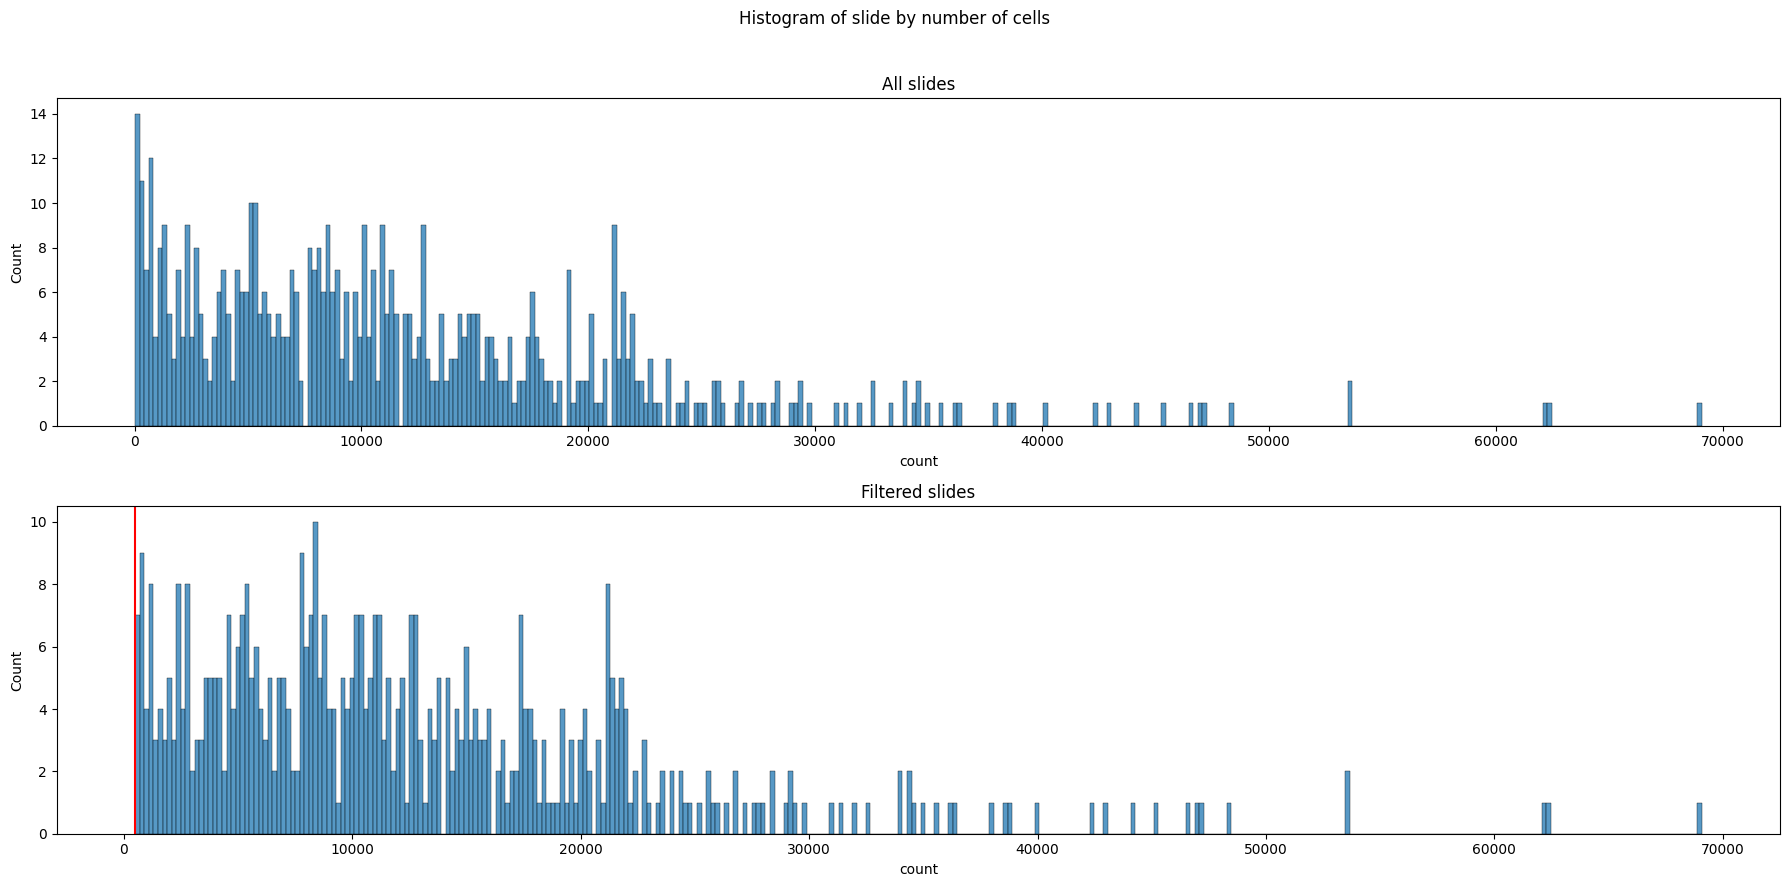

In [28]:
# plotting composition for lowest count slides vs others

figs, axes = plt.subplots(2,1, figsize=(18, 9))
ax0 = sns.histplot(data = composition_df['count'], binwidth = 200, ax = axes[0])
ax0.set_title('All slides')
#ax0.set_title('NSCLC Vectra Cell Count for low count Slides')
#ax0.set_xticklabels(ax1.get_xticklabels(), rotation=45)  # Rotate x ticks


ax1 = sns.histplot(data = filtered.loc[filtered['count'] >= 500]['count'], binwidth = 200, ax = axes[1])
ax1.axvline(x = 500, color = 'r')
ax1.set_title('Filtered slides')
#ax2.set_title('NSCLC Vectra Cell Count for high count Slides')
#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)  # Rotate x ticks

plt.suptitle('Histogram of slide by number of cells')
plt.tight_layout(rect=[0, 0, 1, 0.96])


In [29]:
filtered_slides = list(filtered.index)
filtered_df = subset_df.loc[subset_df['ImageLocation'].isin(filtered_slides)]
filtered_df = filtered_df.loc[~filtered_df['ImageLocation'].isin(low_count_slides)]

In [30]:
# let's check too see if there are any duplicates here
print('Number of unique image locations: ', len(filtered_df['ImageLocation'].unique()), '\n Number of unique ROI fields: ', len(filtered_df['ROI'].unique()))
# looks like we got an ROI represented with 2 image locations 
filtered_df.loc[filtered_df['ROI'] == '15-671_[47512,14698]']['ImageLocation'].unique()
# It's this weird one that has a duplicate entitled M2 component instead of just component

Number of unique image locations:  510 
 Number of unique ROI fields:  509


array(['E:\\Brown 3.21.19\\IMAGES 3.25.19\\MAD15-671_[47512,14698]_M2_component_data.tif',
       'E:\\Brown 3.21.19\\IMAGES 3.25.19\\MAD15-671_[47512,14698]_component_data.tif'],
      dtype=object)

In [31]:
dups = list(filtered_df.loc[filtered_df['ROI'] == '15-671_[47512,14698]']['ImageLocation'].unique())
dups_df = filtered_df.loc[filtered_df['ROI'] == '15-671_[47512,14698]']
dups_df['duplicate #'] = filtered_df['ImageLocation'].apply(lambda x: 1 if x == 'E:\\Brown 3.21.19\\IMAGES 3.25.19\\MAD15-671_[47512,14698]_M2_component_data.tif' else 0)

print(sum(filtered_df['ImageLocation'] == dups[1]), sum(filtered_df['ImageLocation'] == dups[1]))
dups_df.sort_values(by = 'XCenter')[-5:]
# they look to be truly duplicates here, they have the same number of cells
# looking at just the last 5 rows, we can see that 4 of the 5 are basically duplicates, but with ever so slightly different coordinates

/tmp/ipykernel_808196/373268459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups_df['duplicate #'] = filtered_df['ImageLocation'].apply(lambda x: 1 if x == 'E:\\Brown 3.21.19\\IMAGES 3.25.19\\MAD15-671_[47512,14698]_M2_component_data.tif' else 0)


19694 19694


,ImageLocation,XMin,XMax,YMin,YMax,MHCI,CD56,CD8,CD3,IFNy,...,Nucleus Roundness,CD56+PanCyto-,CD56+CD3-,PanCyto+CD3-,PanCyto+MHCI+,PanCyto+MHCI-,PanCyto-CD56-,CD3+CD8-,CD3+CD8+,duplicate #
717635,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-671_[475...,2003.46256,2008.90272,754.69856,763.10608,0.0,1.0,0.0,0.0,0.0,...,0.678114,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
698167,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-671_[475...,2003.46256,2008.90272,754.69856,763.60064,0.0,1.0,0.0,0.0,0.0,...,0.655132,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
717750,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-671_[475...,2002.96800,2009.39728,927.79456,937.68576,0.0,1.0,0.0,0.0,0.0,...,0.571321,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
714291,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-671_[475...,2003.46256,2009.39728,471.81024,478.73408,0.0,0.0,0.0,0.0,0.0,...,0.785420,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
733943,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-671_[475...,2003.46256,2009.39728,471.31568,478.23952,0.0,0.0,0.0,0.0,0.0,...,0.791241,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [32]:
# triple labels with IFN

ImmuneCells = ['CD3+CD8+','CD3+CD8-','CD56+CD3-']

for type in ImmuneCells:
    activatedLabel = type+'IFNy+'
    inactivatedLabel = type+'IFNy-'
    filtered_df[activatedLabel] = filtered_df[type]/2+filtered_df['IFNy']/2
    filtered_df[activatedLabel]= filtered_df[activatedLabel].replace(0.5,0)
    filtered_df[inactivatedLabel] = filtered_df[type]-filtered_df['IFNy']
    filtered_df[inactivatedLabel] = filtered_df[inactivatedLabel].replace(-1,0)

In [43]:
filtered_df['ClassifierLabel']

0           glass
1           glass
2           glass
3           glass
4           glass
            ...  
7046280    stroma
7046281    stroma
7046282    stroma
7046283    stroma
7046284    stroma
Name: ClassifierLabel, Length: 6603633, dtype: object

In [47]:
# triple labels with IFN

Cell_types = ['CD3+CD8+IFNy+','CD3+CD8+IFNy-','CD3+CD8-IFNy+','CD3+CD8-IFNy-','CD56+CD3-IFNy+','CD56+CD3-IFNy-','PanCyto+MHCI+','PanCyto+MHCI-']

for type in Cell_types:
    tumorLabel = type+' Tumor'
    stromaLabel = type+' Stroma'
    glassLabel = type+' Glass'
    filtered_df[tumorLabel] = filtered_df[type]/2+(filtered_df['ClassifierLabel'] == 'tumor').astype(int)/2
    filtered_df[tumorLabel]= filtered_df[tumorLabel].replace(0.5,0)
    filtered_df[stromaLabel] = filtered_df[type]/2+(filtered_df['ClassifierLabel'] == 'stroma').astype(int)/2
    filtered_df[stromaLabel]= filtered_df[stromaLabel].replace(0.5,0)
    filtered_df[glassLabel] = filtered_df[type]/2+(filtered_df['ClassifierLabel'] == 'glass').astype(int)/2
    filtered_df[glassLabel] = filtered_df[glassLabel].replace(0.5,0)

In [55]:
filtered_df.iloc[:,-24:].describe()

,CD3+CD8+IFNy+ Tumor,CD3+CD8+IFNy+ Stroma,CD3+CD8+IFNy+ Glass,CD3+CD8+IFNy- Tumor,CD3+CD8+IFNy- Stroma,CD3+CD8+IFNy- Glass,CD3+CD8-IFNy+ Tumor,CD3+CD8-IFNy+ Stroma,CD3+CD8-IFNy+ Glass,CD3+CD8-IFNy- Tumor,...,CD56+CD3-IFNy+ Glass,CD56+CD3-IFNy- Tumor,CD56+CD3-IFNy- Stroma,CD56+CD3-IFNy- Glass,PanCyto+MHCI+ Tumor,PanCyto+MHCI+ Stroma,PanCyto+MHCI+ Glass,PanCyto+MHCI- Tumor,PanCyto+MHCI- Stroma,PanCyto+MHCI- Glass
count,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,...,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06,6.603633e+06
mean,1.315034e-03,3.716136e-04,9.085908e-07,1.384193e-02,2.603082e-02,3.482931e-05,7.747251e-04,1.293228e-04,1.817182e-06,1.950214e-02,...,2.799974e-04,2.154708e-02,9.896219e-03,1.302313e-03,6.122509e-02,5.740022e-03,2.014043e-05,2.984890e-01,4.031114e-03,2.875690e-04
std,3.623954e-02,1.927370e-02,9.531999e-04,1.168346e-01,1.592270e-01,5.901534e-03,2.782310e-02,1.137128e-02,1.348028e-03,1.382816e-01,...,1.673078e-02,1.451992e-01,9.898629e-02,3.606408e-02,2.397427e-01,7.554519e-02,4.487764e-03,4.575952e-01,6.336296e-02,1.695542e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [58]:
cell_types = []
for i in filtered_df.columns:
    if 'Glass' in i:
        cell_types.append(i)
    elif 'Tumor' in i:
        cell_types.append(i)
    elif 'Stroma' in i:
        cell_types.append(i)

In [59]:
print(len(filtered_df))
filtered_df[cell_types].sum().sort_values()

6603633


CD3+CD8+IFNy+ Glass            6.0
CD3+CD8-IFNy+ Glass           12.0
PanCyto+MHCI+ Glass          133.0
CD3+CD8+IFNy- Glass          230.0
CD3+CD8-IFNy+ Stroma         854.0
CD3+CD8-IFNy- Glass         1152.0
CD56+CD3-IFNy+ Glass        1849.0
PanCyto+MHCI- Glass         1899.0
CD3+CD8+IFNy+ Stroma        2454.0
CD3+CD8-IFNy+ Tumor         5116.0
CD56+CD3-IFNy- Glass        8600.0
CD3+CD8+IFNy+ Tumor         8684.0
CD56+CD3-IFNy+ Stroma      20873.0
PanCyto+MHCI- Stroma       26620.0
PanCyto+MHCI+ Stroma       37905.0
CD56+CD3-IFNy+ Tumor       54478.0
CD56+CD3-IFNy- Stroma      65351.0
CD3+CD8+IFNy- Tumor        91407.0
CD3+CD8-IFNy- Tumor       128785.0
CD56+CD3-IFNy- Tumor      142289.0
CD3+CD8+IFNy- Stroma      171898.0
CD3+CD8-IFNy- Stroma      372879.0
PanCyto+MHCI+ Tumor       404308.0
PanCyto+MHCI- Tumor      1971112.0
dtype: float64

In [60]:
# these distributions are weird. There shouldn't be this many CD56+ cells. It seems like literally all cells on some patients are CD56
# lets remove those patients and see the distributions

# I'm gonna leave this in for now
badPatientIds = ["15-671", "17-234", "17-328", "17-408", "17-473", "17-504", "17-661"]   

print(len(filtered_df.loc[~filtered_df['PatientID'].isin(badPatientIds)]))
filtered_df.loc[~filtered_df['PatientID'].isin(badPatientIds)][cell_types].sum().sort_values()

5307540


CD3+CD8+IFNy+ Glass            3.0
CD3+CD8-IFNy+ Glass            6.0
CD56+CD3-IFNy+ Glass          15.0
PanCyto+MHCI+ Glass           86.0
CD3+CD8+IFNy- Glass          143.0
CD56+CD3-IFNy+ Stroma        592.0
CD56+CD3-IFNy+ Tumor         629.0
CD3+CD8-IFNy+ Stroma         636.0
CD3+CD8-IFNy- Glass          875.0
PanCyto+MHCI- Glass         1439.0
CD3+CD8+IFNy+ Stroma        1545.0
CD56+CD3-IFNy- Glass        1994.0
CD3+CD8-IFNy+ Tumor         2410.0
CD3+CD8+IFNy+ Tumor         4455.0
CD56+CD3-IFNy- Tumor       19096.0
PanCyto+MHCI- Stroma       23271.0
PanCyto+MHCI+ Stroma       32344.0
CD56+CD3-IFNy- Stroma      45947.0
CD3+CD8+IFNy- Tumor        70352.0
CD3+CD8-IFNy- Tumor       114696.0
CD3+CD8+IFNy- Stroma      134274.0
PanCyto+MHCI+ Tumor       304718.0
CD3+CD8-IFNy- Stroma      346545.0
PanCyto+MHCI- Tumor      1564707.0
dtype: float64

In [61]:
cd56_patients = subset_df.loc[subset_df['PatientID'].isin(badPatientIds)]

In [62]:
final_df = filtered_df.loc[~filtered_df['PatientID'].isin(badPatientIds)]

In [63]:
final_df

,ImageLocation,XMin,XMax,YMin,YMax,MHCI,CD56,CD8,CD3,IFNy,...,CD56+CD3-IFNy+ Glass,CD56+CD3-IFNy- Tumor,CD56+CD3-IFNy- Stroma,CD56+CD3-IFNy- Glass,PanCyto+MHCI+ Tumor,PanCyto+MHCI+ Stroma,PanCyto+MHCI+ Glass,PanCyto+MHCI- Tumor,PanCyto+MHCI- Stroma,PanCyto+MHCI- Glass
0,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,2000.00064,2008.40816,402.57184,410.97936,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,1982.19648,1989.61488,575.66784,585.06448,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,1998.02240,2006.42992,696.34048,705.24256,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,1106.82528,1115.72736,172.60144,181.50352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E:\Brown 3.21.19\IMAGES 3.25.19\MAD15-517_[399...,879.32768,885.26240,181.50352,188.42736,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7046280,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,1132.04784,1141.44448,1493.07664,1501.48416,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7046281,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,796.24160,804.15456,1493.57120,1501.48416,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7046282,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,992.08736,998.51664,1494.56032,1501.48416,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7046283,E:\Brown 4.25.19\Unmixed Images 4.29.19\MAD17-...,1102.37424,1111.27632,1495.54944,1502.47328,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
final_df.to_csv('/scratch/gh8sj/brown_nsclc/data/processed_data/cessed_data/tumor_stroma_processed_nsclc_data_4_1_24.csv')

In [5]:
df = pd.read_csv('/scratch/gh8sj/brown_nsclc/data/processed_data/tumor_stroma_processed_nsclc_data_4_1_24.csv')

In [7]:
len(df.ImageLocation.unique())

414

In [10]:
len(df.PatientID.unique())

35

In [11]:
len(df)

5307540